# Fine-tuning Florence-2 on DocVQA

In this notebook, we will fine-tune Florence-2 by MSFT, a new vision language model capable of various tasks, on document question answering.

Let's start by installing the dependencies and loading the dataset.

In [10]:
!pip install -q datasets flash_attn timm einops
!pip install transformers


[notice] A new release of pip is available: 23.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 42.3 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.0/782.0 kB 12.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.7 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 23.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
from datasets import load_dataset, DatasetDict

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data = load_dataset("HuggingFaceM4/DocumentVQA")

Generating test split: 100%|██████████| 5188/5188 [00:44<00:00, 117.23 examples/s]


In [6]:
import os
models_dir = "models/"

os.makedirs(models_dir, exist_ok=True)

In [7]:
data

DatasetDict({
    train: Dataset({
        features: ['questionId', 'question', 'question_types', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers'],
        num_rows: 39463
    })
    validation: Dataset({
        features: ['questionId', 'question', 'question_types', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers'],
        num_rows: 5349
    })
    test: Dataset({
        features: ['questionId', 'question', 'question_types', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers'],
        num_rows: 5188
    })
})

In [42]:
# reducing the size of the dataset
training_size = 10
validation_size = 1
test_size = 1
seed = 42

train_subset = data['train'].shuffle(seed=seed).select(range(training_size))
validation_subset = data['validation'].shuffle(seed=seed).select(range(validation_size))
test_subset = data['test'].shuffle(seed=seed).select(range(test_size))

# Return a new DatasetDict with the reduced sizes
data = DatasetDict({
    'train': train_subset,
    'validation': validation_subset,
    'test': test_subset
})

print(data)

DatasetDict({
    train: Dataset({
        features: ['questionId', 'question', 'question_types', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['questionId', 'question', 'question_types', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers'],
        num_rows: 1
    })
    test: Dataset({
        features: ['questionId', 'question', 'question_types', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers'],
        num_rows: 1
    })
})


We can load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor`  classes of transformers library. Note that we need to pass `trust_remote_code` as `True` since this model is not a transformers model.

In [11]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6').to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
/opt/conda/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto cla

In [41]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

/opt/conda/lib/python3.9/site-packages/torch/cuda/memory.py:282: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Let's do inference with our dataset first to see how the model performs already with our dataset before fine-tuning.

In [13]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=256,
        num_beams=2
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


{'DocVQA': 'no'}


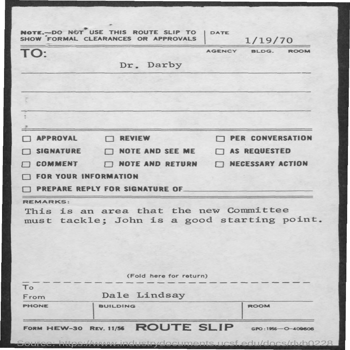

{'DocVQA': '0.0'}


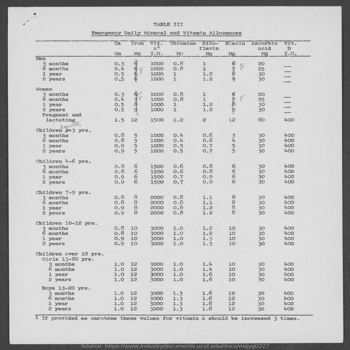

{'DocVQA': 'no'}


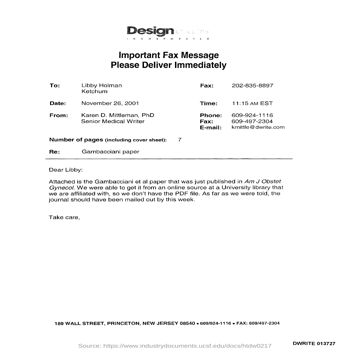

In [14]:
for idx in range(3):
  print(run_example("DocVQA", 'What do you see in this image?', data['train'][idx]['image']))
  display(data['train'][idx]['image'].resize([350, 350]))

We need to construct our dataset. Note how we are adding a new task prefix `<DocVQA>` before the question when constructing the prompt.

In [16]:
from torch.utils.data import Dataset

class DocVQADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<DocVQA>" + example['question']
        first_answer = example['answers'][0]
        image = example['image']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return question, first_answer, image


Let's get to fine-tuning. We will create our dataset, the data collator, and start training. In A100 with 40GB memory, we can fit in 6 examples. If you're training on T4, you can use batch size of 1.

In [45]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (AdamW, AutoProcessor, get_scheduler)

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

# Create datasets
train_dataset = DocVQADataset(data['train'])
val_dataset = DocVQADataset(data['validation'])

# Create DataLoader
batch_size = 2
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

In [49]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=3e-6, output_file='losses.txt'):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )
    
    
    with open(output_file, 'a') as f:
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            i = -1
            for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
                i += 1
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            print(f"Average Training Loss: {avg_train_loss}")

            # Validation phase
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                    inputs, answers = batch

                    input_ids = inputs["input_ids"]
                    pixel_values = inputs["pixel_values"]
                    labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                    outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                    loss = outputs.loss

                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")
            
            # Record the losses to the file
            f.write(f"Epoch {epoch + 1}/{epochs} - Average Training Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}\n")

            # Save model checkpoint
            output_dir = f"{models_dir}/model_checkpoints/epoch_{epoch+1}"
            os.makedirs(output_dir, exist_ok=True)
            model.save_pretrained(output_dir)
            processor.save_pretrained(output_dir)


After training, we will push the model to Hugging Face Hub. To do so, we need to login first with write access. Make sure to pass either write token or fine-grained token (by first creating the repository and setting up fine-grained token access).

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

We will freeze image encoder for this tutorial. The authors have reported improvement in unfreezing image encoder, but note that this will result in more resource usage.

In [50]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

In [51]:
train_model(train_loader, val_loader, model, processor, epochs=10)

Training Epoch 1/10:   0%|          | 0/5 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 14.58 GiB total capacity; 13.27 GiB already allocated; 1.62 MiB free; 13.52 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF